## We'll see if we can improve the standard stack exchange example
* use optimized model and test it against the standard hybrid and pure CF approaches
* We'll also use batches in the optimization method to output checkpoints and restart learning so if something happens, or you end the process prematurely, your search space progress has been saved.

In [1]:
# import modules

import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm import tqdm

from scipy import sparse

import recommender_utils
import sb_utils
import lightfm_hyperopt

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k, reciprocal_rank

import warnings
warnings.filterwarnings("ignore")

/Users/danielokeeffe/miniconda2/envs/basic_ml_36/lib/python3.6/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
# set pandas preferences
pd.options.display.max_columns=50
pd.options.display.max_colwidth=500

In [3]:
# set plot style
sns.set()

## Load data

In [4]:
# We'll try the stack exchange dataset. It's already processed, so we can just go right to the model
from lightfm.datasets import fetch_stackexchange

In [5]:
data = fetch_stackexchange('crossvalidated',
                           test_set_fraction=0.1,
                           indicator_features=False,
                           tag_features=True)

# The train and test split should be done by time, apparently some of the interactions still overlap? Not sure how that happened. We should double check this.
train = data['train']
test = data['test']

In [6]:
print('The dataset has %s users and %s items, '
      'with %s interactions in the test and %s interactions in the training set.'
      % (train.shape[0], train.shape[1], test.getnnz(), train.getnnz()))

The dataset has 3213 users and 72360 items, with 4453 interactions in the test and 57795 interactions in the training set.


## Note:
In older versions of LightFM there is a bug in the processing of this provided dataset.  You'll know if you have this version if you run the "test_auc_cf = ..." line below.  If this is the case you can, for now, change check_intersections=False". To fix the bug permanently, either upgrade your version of LightFM, or in the LightFM pacakge, change the stackexchange.py file in the Datasets directory.  Around line 100, you'll see a line that looks like "tag_feature_mat = sp.coo_matrix(...)".  Below that line, add "interactions.sum_duplicates()". Save and restart your kernel, and you should be good to go.

In [8]:
# test_coo = test.tocsr().tocoo()

## Pure Collaborative Filtering (CF)

In [9]:
# Set the number of threads to use.  If you have lots, give it a try.
NUM_THREADS = 1

In [10]:
model_cf = LightFM(loss='warp')

In [11]:
model_cf = model_cf.fit(train, num_threads=NUM_THREADS)

In [12]:
# Training set performance
train_auc_cf = auc_score(model_cf, train, num_threads=NUM_THREADS).mean()
print('Collaborative filtering train AUC: %s' % train_auc_cf)

Collaborative filtering train AUC: 0.7635599


In [13]:
# Test set performance. Note that this isn't a pure cold start problem due to apparently 5 overlapping interactions between the train and test set.  It's probably not a big deal 
# given the size of the test set. 
test_auc_cf = auc_score(model_cf, test, train_interactions=train, num_threads=NUM_THREADS, check_intersections=True).mean()
print('Collaborative filtering test AUC: %s' % test_auc_cf)

Collaborative filtering test AUC: 0.40029788


Despite the possible overlapping interactions between train and test, this is a terrible model.  The reason is that there is no training data for most of the items in the test set, so a CF model just can't compute a reasonable representation of the test set items.  Remember, the training set contains all of the users and items, but positive interaction between them is
masked.  The test set also contains all of the user and items, but the test interactions are now unmasked and the model is asked to recommend on these examples.  The results are then
compared to the true outcomes.  CF models are notoriously bad at this kind of thing since they rely entirely on interactions between known users and items.  If there are new user and/
or items, the model cannot use its already learned reprentations to do anything sensible.  

## Out of the box hybrid model
* The hybrid model will use features about the available items to compute more generalizable representations of them.
* When asked to recommend on an item it has not seen in the training set, it will fall back on these representations to make a prediction

In [14]:
item_features = data['item_features']
tag_labels = data['item_feature_labels']

print('There are %s distinct tags, with values like %s.' % (item_features.shape[1], tag_labels[:3].tolist()))

There are 1246 distinct tags, with values like ['bayesian', 'prior', 'elicitation'].


In [15]:
model_hybrid_base = LightFM(loss='warp')

In [16]:
model_hybrid_base = model_hybrid_base.fit(train,
                                          item_features=item_features,
                                          num_threads=NUM_THREADS)

In [17]:
# Train auc
train_auc_hybrid_base = auc_score(model_hybrid_base,
                                  train,
                                  item_features=item_features,
                                  num_threads=NUM_THREADS).mean()
print('Hybrid base training set AUC: %s' % train_auc_hybrid_base)

Hybrid base training set AUC: 0.7427175


In [18]:
# Test auc
test_auc_hybrid_base = auc_score(model_hybrid_base,
                                 test,
                                 item_features=item_features,
                                 num_threads=NUM_THREADS,
                                 check_intersections=True).mean()
print('Hybrid test set AUC: %s' % test_auc_hybrid_base)

Hybrid test set AUC: 0.6758338


In [19]:
# Much better.  This is a significant improvement. No big surprise, the cold start problem can now be approach sensibly

## Improved model
* Let's see if we can ramp this up
* If we can't improve the data we're using, then the issue becomes one of model optimization.  In particular, the hyperparameters are not inutative to set.  For example, one of the hyperparameters is the number of components to use in constructing the item and user embedding matrices.  The dimensionality of this matrix is not obvious and we should explore a range to see if we can figure out an appropriate value.
* We'll use a Bayesian approach to explore the possible space of parameters
* The lightfm_hyperopt module provides helper functions to let hyperopt work with the LightFM hybrid recommender model
* Hyperopt is a python package that allows you to use a version of Sequential Model Based Optimization (SMBO). 
* SMBO is a general framework for using Bayesian inference with a surrogate model, which provides a proxy for the full function you want to evaluate (in this case, the actual model fit) which is expensive to evaluate.  A full description of how this works is beyond the scope of this example
* The module exposes two options for model hyperparameter search.  Tree Parzen estimators (which is a Bayesian technique, i.e. the prior distribution is a combination of Parzen estimators, also called kernel density estimates), and random search (non-Bayesian technique)
* The lightfm_hyperopt module also gives you the option to search the parameter space in batches, outputing checkpoints at a desired frequency of evaluations.  The number of evaluations (i.e. iterations) you run the search for is an input.  Too few and you won't properly explore the space, too many and you're wasting time.  By checkpointing, you can stop the evaluation and record the last best recorded solution.
* TODO: Add support for early stopping, ending the search after non-improvement has been detected for some n number of evaluations

In [20]:
# Define the space of possible hyperparameters and fit parameters for the model
hyperparams_dict = {'no_components': ['choice', range(40, 100)],
                    'learning_schedule': ['choice', ['adagrad', 'adadelta']],
                    'loss': ['choice', ['warp']],
                    'learning_rate': ['uniform', [0.01, 0.1]],
                    'item_alpha': ['uniform', [0, 1e-5]]}
fit_params_dict = {'num_threads': 1, 'num_epochs': ['choice', range(30, 50)]}

In [21]:
# Run with 3 fold cross validation. Run for 30 maximum evaluations, with checkpoints every 10 evaluations
best, trials = lightfm_hyperopt.fit_model_batch(interactions=train, 
                                                hyperparams_dict=hyperparams_dict, 
                                                fit_params_dict=fit_params_dict, 
                                                test_percentage=0.2, 
                                                item_features=item_features, 
                                                cv=3, 
                                                max_evals=30,
                                                batch_size=10,
                                                eval_metric='auc_score',
                                                verbose=0)

Running hyperopt hyperparameter search
Running in cross validation mode for 3 folds
Running for 30 evaluations in batches of 10 for a total of 3 batches
completed fold: 1
completed fold: 2
completed fold: 3
completed all folds in current iteration, starting next iteration
completed fold: 1
completed fold: 2
completed fold: 3
completed all folds in current iteration, starting next iteration
completed fold: 1
completed fold: 2
completed fold: 3
completed all folds in current iteration, starting next iteration
completed fold: 1
completed fold: 2
completed fold: 3
completed all folds in current iteration, starting next iteration
completed fold: 1
completed fold: 2
completed fold: 3
completed all folds in current iteration, starting next iteration
completed fold: 1
completed fold: 2
completed fold: 3
completed all folds in current iteration, starting next iteration
completed fold: 1
completed fold: 2
completed fold: 3
completed all folds in current iteration, starting next iteration
complet

In [22]:
# This function will format the output best found hyperparameters and save them as a json file with your choice of name.  This will let you
# re-load them at a future date should you desire to, without the need to re-run the parameter space search.
best_params = lightfm_hyperopt.get_best_hyperparams(hyperparams_dict=hyperparams_dict, 
                                                    fit_params_dict=fit_params_dict, 
                                                    best=best, 
                                                    file_name='best_params_3_fold_cv_stackexchange_20191017a.json')

In [23]:
best_params

{'item_alpha': 1.190990781508593e-06,
 'learning_rate': 0.021908539753897442,
 'learning_schedule': 'adagrad',
 'loss': 'warp',
 'no_components': 43,
 'num_epochs': 46}

In [24]:
# Remove num_epochs since this is a fit parameter.  
num_epochs = best_params.pop('num_epochs')

In [25]:
# Re-train model with 5 fold cross validation on all available training data. This let's you do what is essentially nested
# cross validation.
model_train, cv_scores = lightfm_hyperopt.fit_cv(params=best_params, 
                                                 interactions=train, 
                                                 eval_metric='auc_score', 
                                                 num_epochs=num_epochs, 
                                                 num_threads=1, 
                                                 test_percentage=0.2, 
                                                 item_features=item_features, 
                                                 cv=5, 
                                                 seed=0, 
                                                 refit=True,
                                                 verbose=0)

Fitting model in cross validation mode for 5 folds
Completed fold: 1
Fold 1 loss: 0.7369223833084106
Completed fold: 2
Fold 2 loss: 0.733478307723999
Completed fold: 3
Fold 3 loss: 0.7365027070045471
Completed fold: 4
Fold 4 loss: 0.7347378730773926
Completed fold: 5
Fold 5 loss: 0.7344011068344116
Cross validation complete.
Refitting model to all provided training data


In [26]:
# Train auc
train_auc_hyperopt = auc_score(model_train,
                               train,
                               item_features=item_features,
                               num_threads=NUM_THREADS).mean()
print('Hybrid hyperopt training set AUC: %s' % train_auc_hyperopt)

Hybrid hyperopt training set AUC: 0.9391249


In [27]:
# Test auc
test_auc_hyperopt = auc_score(model_train,
                              test,
                              item_features=item_features,
                              num_threads=NUM_THREADS,
                              check_intersections=True).mean()
print('Hybrid base test set AUC: %s' % test_auc_hyperopt)

Hybrid base test set AUC: 0.76568323


In [28]:
# This is a significant improvement over the out of the box hybrid recommender model

In [29]:
# The recommender_utils module has a bunch of helper functions for computing evaluation metrics.
eval_results_dict = recommender_utils.compute_eval_metrics(model=model_train, 
                                                           train_interactions=train, 
                                                           test_interactions=test, 
                                                           item_features=item_features, 
                                                           compute_on_train=True,
                                                           preserve_rows=False,
                                                           check_intersections=False)

Computing test set AUCs
Computing test set recalls at 10
Computing test set recalls at 20
Computing test set recalls at 50
Computing test set precisions at 10
Computing test set precisions at 20
Computing test set precisions at 50
Computing test set reciprocal rank
Computing metrics on training set as well
Computing train set AUCs
Computing train set recalls at 10
Computing train set recalls at 20
Computing train set recalls at 50
Computing train set precisions at 10
Computing train set precisions at 20
Computing train set precisions at 50
Computing train set reciprocal rank


In [30]:
eval_summary_df = recommender_utils.compute_eval_metric_summaries(eval_dict=eval_results_dict)

In [31]:
# Compare this to the out of the box hybrid recommender.  The test set evaluation metrics should all be slightly better in the optimized
# model.
eval_results_baseline_dict = recommender_utils.compute_eval_metrics(model=model_hybrid_base, 
                                                                    train_interactions=train, 
                                                                    test_interactions=test, 
                                                                    item_features=item_features, 
                                                                    compute_on_train=True,
                                                                    preserve_rows=False,
                                                                    check_intersections=False)

Computing test set AUCs
Computing test set recalls at 10
Computing test set recalls at 20
Computing test set recalls at 50
Computing test set precisions at 10
Computing test set precisions at 20
Computing test set precisions at 50
Computing test set reciprocal rank
Computing metrics on training set as well
Computing train set AUCs
Computing train set recalls at 10
Computing train set recalls at 20
Computing train set recalls at 50
Computing train set precisions at 10
Computing train set precisions at 20
Computing train set precisions at 50
Computing train set reciprocal rank


In [32]:
eval_baseline_summary_df = recommender_utils.compute_eval_metric_summaries(eval_dict=eval_results_baseline_dict)

In [33]:
eval_baseline_summary_df

,metric,number_observations,min,max,mean,variance,skewness,kurtosis,median,25th percentile,75th percentile
0,test_auc,615,0.003054,0.999724,0.676032,0.055808,-0.739972,-0.007057,0.711047,0.535540,0.711047
1,test_recall_at_10,615,0.000000,0.066667,0.000400,0.000018,12.587138,169.126522,0.000000,0.000000,0.000000
2,test_recall_at_20,615,0.000000,0.200000,0.001080,0.000106,14.142572,239.735544,0.000000,0.000000,0.000000
3,test_recall_at_50,615,0.000000,1.000000,0.006327,0.002859,13.575886,217.605567,0.000000,0.000000,0.000000
4,test_precision_at_10,615,0.000000,0.400000,0.001951,0.000420,14.503047,248.946871,0.000000,0.000000,0.000000
5,test_precision_at_20,615,0.000000,0.350000,0.001951,0.000338,14.224979,235.837303,0.000000,0.000000,0.000000
6,test_precision_at_50,615,0.000000,0.140000,0.001691,0.000104,9.140030,100.182050,0.000000,0.000000,0.000000
7,test_reciprocal_rank,615,0.000014,0.500000,0.005401,0.001104,11.967932,164.278840,0.000160,0.000047,0.000160
8,train_auc,3213,0.064706,0.998694,0.742718,0.022084,-0.521726,0.202894,0.749796,0.643136,0.749796
9,train_recall_at_10,3213,0.000000,0.500000,0.002012,0.000683,16.811543,301.458476,0.000000,0.000000,0.000000


In [34]:
eval_summary_df

,metric,number_observations,min,max,mean,variance,skewness,kurtosis,median,25th percentile,75th percentile
0,test_auc,615,0.036321,0.999972,0.765974,0.048936,-1.176507,0.924472,0.835374,0.641667,0.835374
1,test_recall_at_10,615,0.000000,1.000000,0.006023,0.003892,14.152492,214.124724,0.000000,0.000000,0.000000
2,test_recall_at_20,615,0.000000,1.000000,0.010895,0.006281,10.491609,121.013623,0.000000,0.000000,0.000000
3,test_recall_at_50,615,0.000000,1.000000,0.021260,0.011759,7.105824,55.794976,0.000000,0.000000,0.000000
4,test_precision_at_10,615,0.000000,0.400000,0.004065,0.000781,9.035782,97.654405,0.000000,0.000000,0.000000
5,test_precision_at_20,615,0.000000,0.450000,0.004146,0.000663,11.298878,165.021750,0.000000,0.000000,0.000000
6,test_precision_at_50,615,0.000000,0.220000,0.003187,0.000227,8.515950,93.514220,0.000000,0.000000,0.000000
7,test_reciprocal_rank,615,0.000014,1.000000,0.016097,0.008051,9.351852,94.821940,0.000393,0.000095,0.000393
8,train_auc,3213,0.702158,0.999910,0.939125,0.003529,-1.201251,0.863961,0.959141,0.906653,0.959141
9,train_recall_at_10,3213,0.000000,1.000000,0.009396,0.003519,8.157085,75.351889,0.000000,0.000000,0.000000


We can visualize the distribution of AUC scores across all the users in the test set for the out of the box hybrid model and the optimized model. This can be useful for understanding how well the model is performing across the entire test population.  The model doesn't produce an interpretable score like a traditional classifier (the score produced by the hybrid model is just a rank order score for the recommendations, it has no other interpretation and in particular is not really sensible to point compare across different user/item recommendations). In this sense, looking at the AUC distribution is kind of a proxy for looking at the score distribution of a traditional classifier

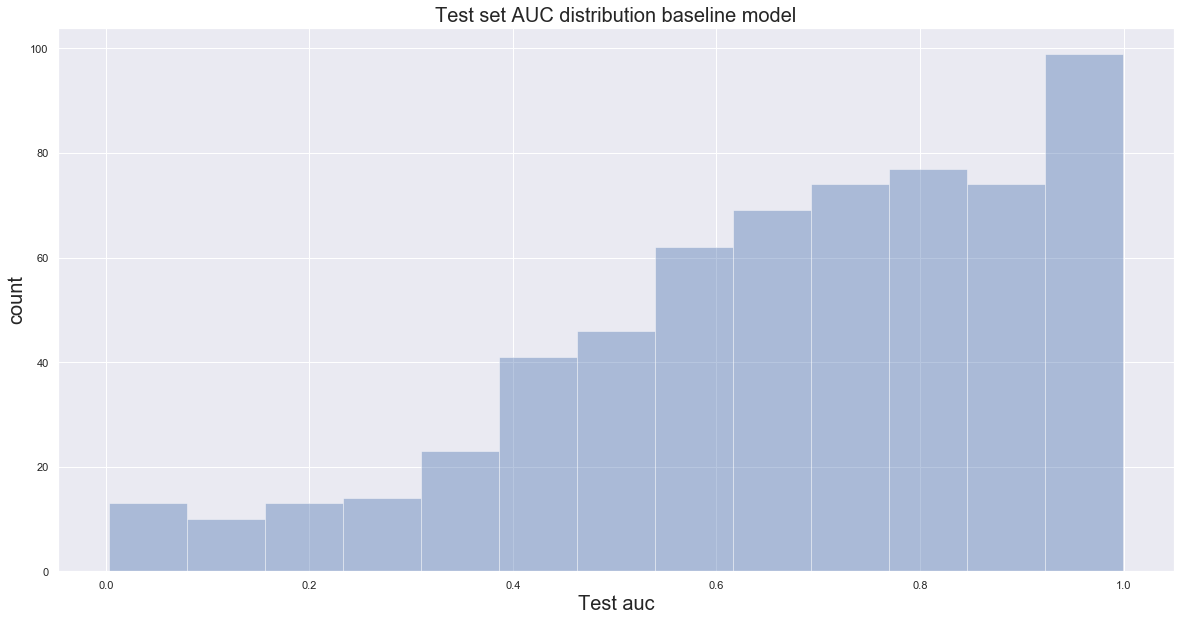

In [35]:
recommender_utils.plot_metric_dist(eval_dict=eval_results_baseline_dict, 
                                   metric='auc', 
                                   data_split='test', 
                                   title='Test set AUC distribution baseline model', 
                                   axis_fontsize=20, 
                                   title_fontsize=20)

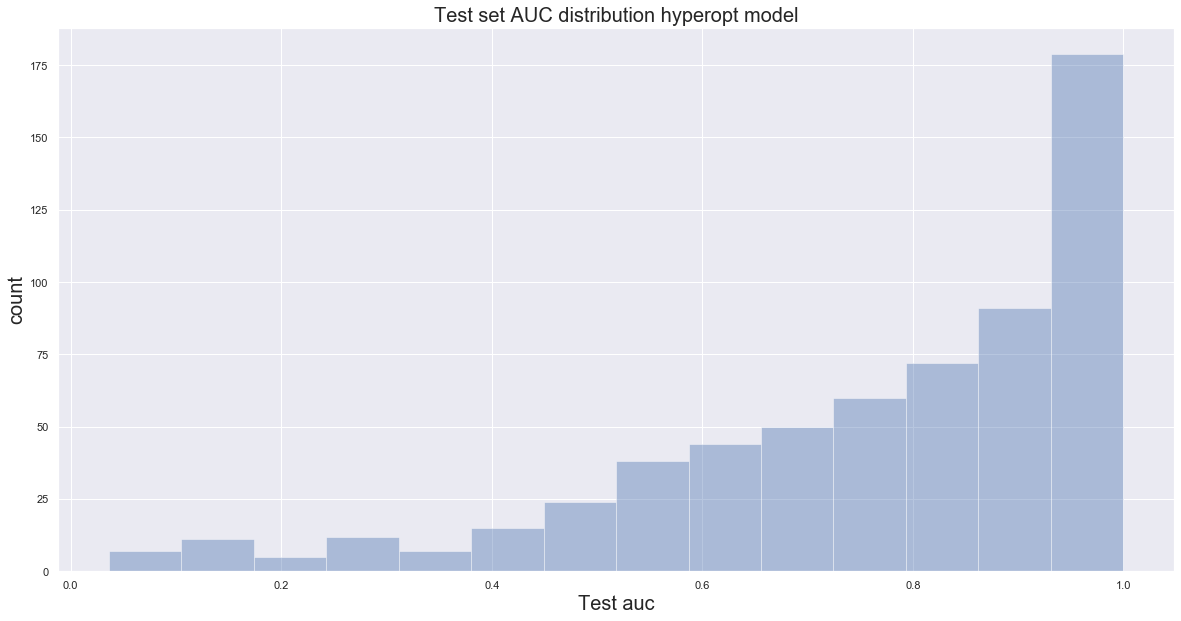

In [36]:
recommender_utils.plot_metric_dist(eval_dict=eval_results_dict, 
                                   metric='auc', 
                                   data_split='test', 
                                   title='Test set AUC distribution hyperopt model', 
                                   axis_fontsize=20, 
                                   title_fontsize=20)